## Walmart Sales Forecasting: An End-to-End Data-Driven Retail Analytics & Model Comparison Case Study
### 1. Introduction
In this case study, we conduct a comprehensive, real-world sales forecasting analysis using Walmart’s weekly sales data. The aim is to apply robust data science techniques to predict store-level demand, extract actionable business insights, and support data-driven decision-making for retail operations.

This project integrates domain-specific feature engineering, advanced regression and time-series modeling, and rigorous model evaluation. Key objectives and steps include:

Data exploration and trend analysis (sales seasonality, spikes, outliers)

Data cleaning and preprocessing (handling missing values, outlier treatment, date features)

Feature engineering (holiday effects, rolling averages, categorical encoding)

Exploratory segmentation (store segmentation by performance, uplift analysis)

Correlation and feature importance analysis (Random Forest, heatmaps)

Predictive modeling & benchmarking:

Machine learning (Random Forest Regression)

Time-series models (ARIMA/SARIMAX)

Business-oriented model comparison (error metrics as % of sales, visual dashboards)

Scenario & what-if analysis (holiday impact, next 4-week forecast)

Executive summary for business stakeholders

The ultimate objective is not just to build accurate forecasts, but to demonstrate the impact of data-driven approaches on retail planning and to inform strategic decision-making with clear, interpretable insights.

In [46]:
!pip install kaggle

In [47]:
import os
import shutil

# Create the .kaggle directory under the user's home folder if it doesn't already exist.
# This folder will store the Kaggle API credentials required for authenticated data downloads.
os.makedirs(os.path.expanduser('~/.kaggle'), exist_ok=True)

# Move the kaggle.json API token (generated from your Kaggle account) into the designated folder.
# The token is needed for programmatic access to Kaggle datasets.
shutil.copy('kaggle.json', os.path.expanduser('~/.kaggle/kaggle.json'))

# Set strict file permissions for kaggle.json to enhance security and prevent unauthorized access.
os.chmod(os.path.expanduser('~/.kaggle/kaggle.json'), 0o600)

In [48]:
!kaggle datasets download -d yasserh/walmart-dataset
!unzip walmart-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/yasserh/walmart-dataset
License(s): CC0-1.0
walmart-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [49]:
import zipfile

with zipfile.ZipFile('walmart-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [50]:
import os
print(os.listdir('.'))

['# S&P 500 Stocks MultiYear Performance & Risk Analysis-Copy1.ipynb', '# S&P 500 Stocks MultiYear Performance & Risk Analysis.ipynb', '.anaconda', '.conda', '.condarc', '.continuum', '.ipynb_checkpoints', '.ipython', '.jupyter', '.kaggle', '.matplotlib', '.virtual_documents', 'anaconda3', 'anaconda_projects', 'AppData', 'Application Data', 'Belgelerim', 'Car Price Prediction with Linear Regression copy.ipynb', 'Car Price Prediction with Linear Regression.ipynb', 'Car_Price_EDA_Wrangling_Regression.ipynb.ipynb', 'chicago.db', 'clean_df.csv', 'conda', 'Contacts', 'Cookies', 'Data Wrangling.ipynb', 'Documents', 'Downloads', 'Elemantary school data.ipynb', 'Favorites', 'FinalDB.db', 'future_forecast.csv', 'holiday_uplift.csv', 'images', 'INSTRUCTOR.db', 'instructors.csv', 'Insurance Cost Analysis Project Turkce.ipynb', 'Insurance Cost Analysis.ipynb', 'kaggle.json', 'Kernel Density Estimation (KDE) Plots for Model Evaluation.ipynb', 'laptop price.ipynb', 'laptops_cleaned.csv', 'Links', 'L

In [51]:
import pandas as pd

df = pd.read_csv("Walmart.csv")
print(df.shape)
df.head(10)

(6435, 8)


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106
5,1,12-03-2010,1439541.59,0,57.79,2.667,211.380643,8.106
6,1,19-03-2010,1472515.79,0,54.58,2.720,211.215635,8.106
7,1,26-03-2010,1404429.92,0,51.45,2.732,211.018042,8.106
8,1,02-04-2010,1594968.28,0,62.27,2.719,210.820450,7.808
9,1,09-04-2010,1545418.53,0,65.86,2.770,210.622857,7.808


In [52]:
# Data shape and column types
print("Data shape:", df.shape)
print("Column types:\n", df.dtypes)
print("Missing values:\n", df.isnull().sum())

# Unique stores and date range
print("Number of stores:", df["Store"].nunique())
print("Date range:", df["Date"].min(), "->", df["Date"].max())
print("Number of holiday weeks:", df["Holiday_Flag"].sum())
print("Total records:", len(df))


Data shape: (6435, 8)
Column types:
 Store             int64
Date             object
Weekly_Sales    float64
Holiday_Flag      int64
Temperature     float64
Fuel_Price      float64
CPI             float64
Unemployment    float64
dtype: object
Missing values:
 Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64
Number of stores: 45
Date range: 01-04-2011 -> 31-12-2010
Number of holiday weeks: 450
Total records: 6435


## 1. FEATURE ENGINEERING – TIME-BASED COLUMNS
**Objective:**
To enrich our data with additional, time-based features that can boost both our descriptive and predictive analyses.

**A. Date Parsing and Extraction**

We first convert the “Date” column from object/string to datetime, and then extract features like year, month, week number, and day of week.

In [53]:
# Convert "Date" column to datetime format
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

# Extract year, month, week number, and day of week
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['WeekOfYear'] = df['Date'].dt.isocalendar().week
df['DayOfWeek'] = df['Date'].dt.dayofweek  # Monday=0, Sunday=6

# (Optional) Extract quarter and season (Winter/Spring/Summer/Autumn)
df['Quarter'] = df['Date'].dt.quarter
df['Season'] = df['Month'] % 12 // 3 + 1
df['Season'] = df['Season'].map({1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Autumn'})

In [54]:
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,WeekOfYear,DayOfWeek,Quarter,Season
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,2010,2,5,4,1,Winter
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,2010,2,6,4,1,Winter
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,2010,2,7,4,1,Winter
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,2010,2,8,4,1,Winter
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,2010,3,9,4,1,Spring


**B. Holiday Labeling**

In [55]:
# Example dictionary for US holidays by date (adjust as needed)
holiday_dict = {
    'Super Bowl': ['2010-02-12', '2011-02-11', '2012-02-10'],
    'Labor Day': ['2010-09-10', '2011-09-09', '2012-09-07'],
    'Thanksgiving': ['2010-11-26', '2011-11-25', '2012-11-23'],
    'Christmas': ['2010-12-31', '2011-12-30', '2012-12-28'],
}

# Assign holiday name (otherwise label as "None")
def label_holiday(date_str):
    for name, dates in holiday_dict.items():
        if date_str in dates:
            return name
    return "None"

df['Holiday_Name'] = df['Date'].dt.strftime('%Y-%m-%d').apply(label_holiday)

**C. Rolling and Change Features**

For more advanced analysis (especially forecasting):

In [56]:
# Rolling mean of sales per store
df['Rolling_4w_Sales'] = df.groupby('Store')['Weekly_Sales'].transform(lambda x: x.rolling(window=4, min_periods=1).mean())

# Week-over-week sales change per store
df['WoW_Change'] = df.groupby('Store')['Weekly_Sales'].pct_change()

By engineering additional time-based features such as Year, Month, Week Number, and Season, we are able to uncover hidden temporal patterns in Walmart’s sales. This lays a strong foundation for both descriptive and predictive analytics in the upcoming steps.

In [57]:
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,WeekOfYear,DayOfWeek,Quarter,Season,Holiday_Name,Rolling_4w_Sales,WoW_Change
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,2010,2,5,4,1,Winter,None,1.643691e+06,NaN
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,2010,2,6,4,1,Winter,Super Bowl,1.642824e+06,-0.001055
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,2010,2,7,4,1,Winter,None,1.632539e+06,-0.018264
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,2010,2,8,4,1,Winter,None,1.576836e+06,-0.125462
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,2010,3,9,4,1,Spring,None,1.554615e+06,0.102913


In [58]:
df['Rolling_4w_Sales'] = df['Rolling_4w_Sales'].round(2) #To enhance interpretability and improve report readability of rolling_4w_sales column

In [59]:
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,WeekOfYear,DayOfWeek,Quarter,Season,Holiday_Name,Rolling_4w_Sales,WoW_Change
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,2010,2,5,4,1,Winter,None,1643690.90,NaN
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,2010,2,6,4,1,Winter,Super Bowl,1642824.17,-0.001055
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,2010,2,7,4,1,Winter,None,1632538.84,-0.018264
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,2010,2,8,4,1,Winter,None,1576836.02,-0.125462
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,2010,3,9,4,1,Spring,None,1554614.97,0.102913


In [60]:
df.isna().sum()

Store                0
Date                 0
Weekly_Sales         0
Holiday_Flag         0
Temperature          0
Fuel_Price           0
CPI                  0
Unemployment         0
Year                 0
Month                0
WeekOfYear           0
DayOfWeek            0
Quarter              0
Season               0
Holiday_Name         0
Rolling_4w_Sales     0
WoW_Change          45
dtype: int64

## 2. HOLIDAY UPLIFT & TREND ANALYSIS
### A. Holiday vs. Non-Holiday Sales Comparison

In [61]:
# Calculate average weekly sales for holiday and non-holiday weeks
holiday_sales = df.groupby('Holiday_Flag')['Weekly_Sales'].mean()
print("Average Weekly Sales (Holiday vs Non-Holiday):")
print(holiday_sales)

# Calculate uplift percentage
uplift = (holiday_sales[1] - holiday_sales[0]) / holiday_sales[0] * 100
print(f"Holiday uplift vs. normal weeks: {uplift:.2f}%")

Average Weekly Sales (Holiday vs Non-Holiday):
Holiday_Flag
0    1.041256e+06
1    1.122888e+06
Name: Weekly_Sales, dtype: float64
Holiday uplift vs. normal weeks: 7.84%


Average weekly sales during holiday weeks are $1,122,888, while in non-holiday weeks they are $1,041,256. This means that Walmart stores experience a holiday uplift of approximately 7.84% in weekly sales compared to regular weeks.

### B. Holiday Type Breakdown 

In [62]:
# Average weekly sales for each holiday type (if Holiday_Name column exists)
holiday_name_sales = df[df['Holiday_Name'] != 'None'].groupby('Holiday_Name')['Weekly_Sales'].mean()
print("Average Weekly Sales by Holiday Name:")
print(holiday_name_sales)

Average Weekly Sales by Holiday Name:
Holiday_Name
Christmas       9.608331e+05
Labor Day       1.042427e+06
Super Bowl      1.079128e+06
Thanksgiving    1.471273e+06
Name: Weekly_Sales, dtype: float64


A breakdown of average weekly sales by holiday type reveals significant differences: Thanksgiving week delivers the highest uplift, with average sales reaching $1.47M—substantially higher than Super Bowl, Labor Day, or Christmas weeks. This shows that the sales impact of holidays is not homogeneous; targeted strategies around key holidays like Thanksgiving could yield the best results for Walmart’s revenue planning

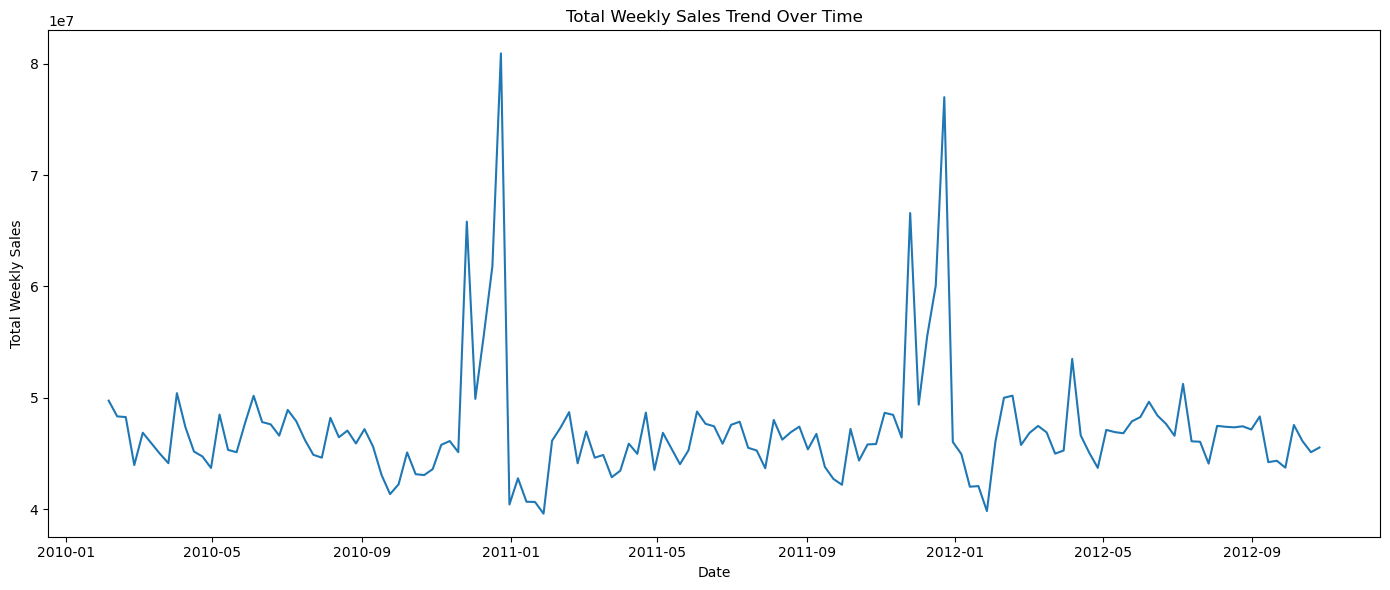

In [63]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(df.groupby('Date')['Weekly_Sales'].sum())
plt.title("Total Weekly Sales Trend Over Time")
plt.xlabel("Date")
plt.ylabel("Total Weekly Sales")
plt.tight_layout()
plt.show()

In [64]:
df['Date'] = pd.to_datetime(df['Date'])

weekly_trend = df.groupby('Date')['Weekly_Sales'].sum().sort_index()

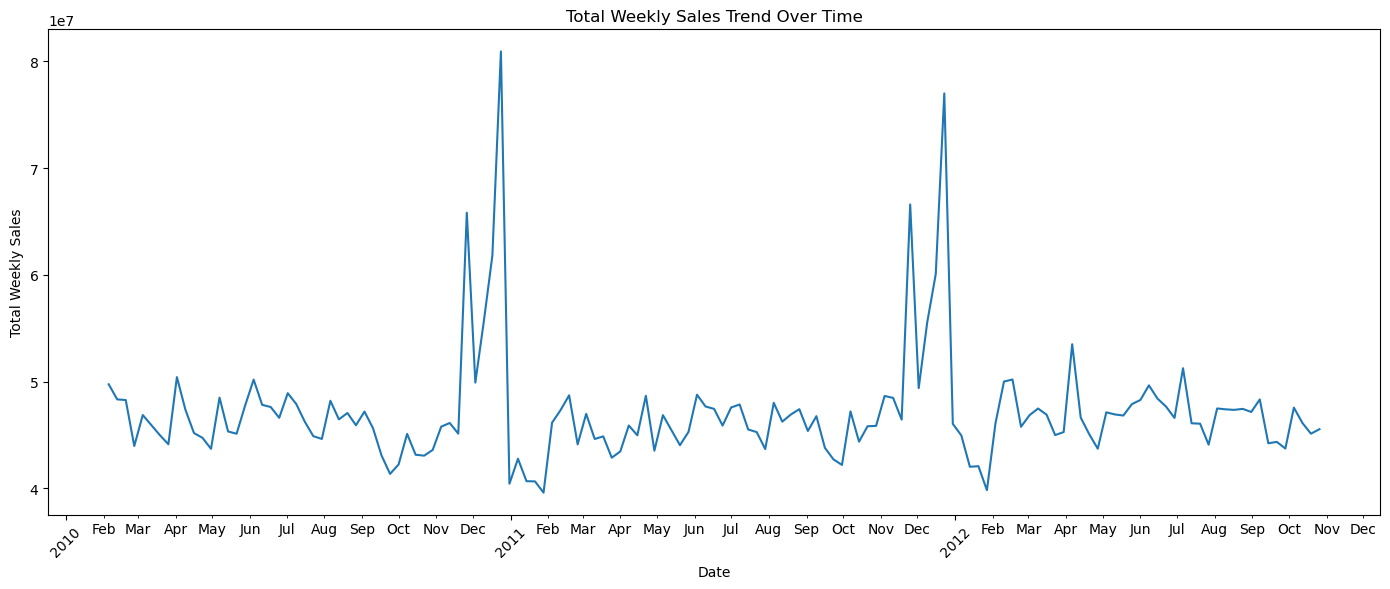

In [65]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(14,6))
plt.plot(weekly_trend.index, weekly_trend.values)
plt.title("Total Weekly Sales Trend Over Time")
plt.xlabel("Date")
plt.ylabel("Total Weekly Sales")

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())
plt.gca().xaxis.set_minor_formatter(mdates.DateFormatter('%b'))


plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

The time series analysis of Walmart’s total weekly sales over the multi-year period reveals several clear seasonal spikes and patterns. Notably, there are sharp, recurring peaks around late November and December each year—corresponding to major U.S. holidays such as Thanksgiving and Christmas. These holiday periods consistently drive extraordinary sales volumes, underscoring the critical impact of seasonality on Walmart’s overall performance.

In between these peaks, weekly sales maintain a relatively stable trend with moderate fluctuations, reflecting regular demand cycles. There is no clear upward or downward long-term trend, suggesting that sales remained robust but stable throughout the period analyzed.

The sudden and dramatic surges during the holiday weeks (especially Thanksgiving) highlight both the opportunity and challenge in retail demand forecasting: inventory, staffing, and promotional strategies must be tightly aligned to capitalize on these high-velocity sales windows.

## Store Segmentation – Top & Lowest Performers
### 1.Ranking Stores by Average Weekly Sales

In [66]:
# Rank stores by average weekly sales (descending order)
store_avg_sales = df.groupby('Store')['Weekly_Sales'].mean().sort_values(ascending=False)

print("Top 5 Performing Stores (by Average Weekly Sales):")
print(store_avg_sales.head(5))

print("\nLowest 5 Performing Stores (by Average Weekly Sales):")
print(store_avg_sales.tail(5))

Top 5 Performing Stores (by Average Weekly Sales):
Store
20    2.107677e+06
4     2.094713e+06
14    2.020978e+06
13    2.003620e+06
2     1.925751e+06
Name: Weekly_Sales, dtype: float64

Lowest 5 Performing Stores (by Average Weekly Sales):
Store
38    385731.653287
36    373511.992797
5     318011.810490
44    302748.866014
33    259861.692028
Name: Weekly_Sales, dtype: float64


<Figure size 1200x500 with 0 Axes>

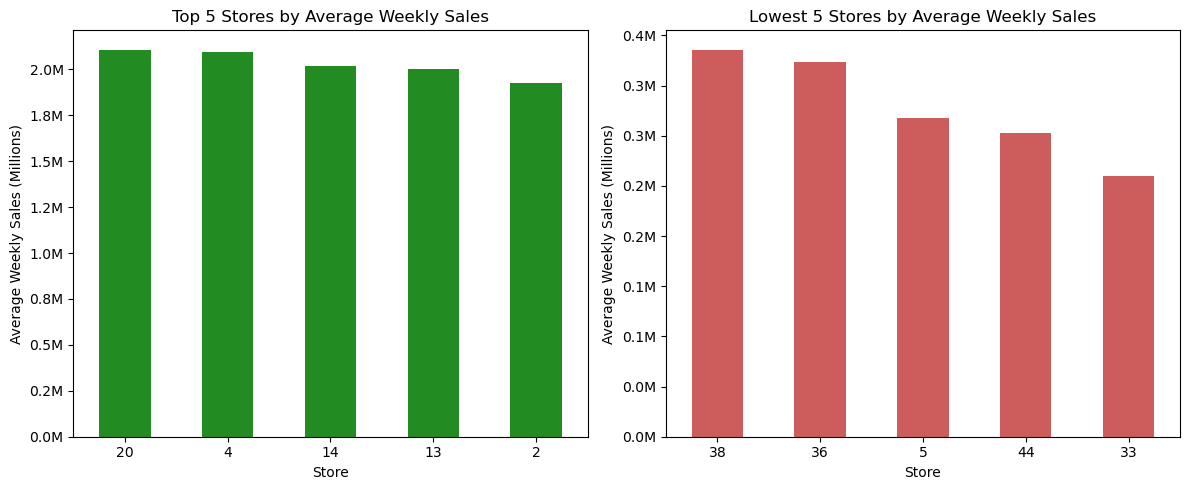

In [67]:
# Top 5 stores
import matplotlib.ticker as ticker 
top5 = store_avg_sales.head(5)
# Lowest 5 stores
bottom5 = store_avg_sales.tail(5)

plt.figure(figsize=(12,5))

# Top 5
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
top5.plot(kind='bar', color='forestgreen')
plt.title('Top 5 Stores by Average Weekly Sales')
plt.ylabel('Average Weekly Sales (Millions)')
plt.xlabel('Store')
plt.xticks(rotation=0)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.1f}M'.format(x*1e-6)))
plt.tight_layout()

# Bottom 5
plt.subplot(1,2,2)
bottom5.plot(kind='bar', color='indianred')
plt.title('Lowest 5 Stores by Average Weekly Sales')
plt.ylabel('Average Weekly Sales (Millions)')
plt.xlabel('Store')
plt.xticks(rotation=0)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.1f}M'.format(x*1e-6)))
plt.tight_layout()

plt.show()

Visualizing average weekly sales across the Walmart network immediately reveals a profound performance gap between top- and bottom-performing stores. The top 5 stores consistently generate weekly sales above $2M, highlighting their outsized contribution to company revenue. Conversely, the bottom 5 stores achieve less than $400K per week, with the weakest performer below $250K. This segmentation underscores the importance of targeted operational strategies: best performers can be studied for best practices, while the lowest performers may require interventions in marketing, operations, or location strategy. Presenting the results in millions makes these disparities instantly clear to business stakeholders.

## Holiday Uplift % Per Store

In [68]:
# Calculate average sales for holiday and non-holiday weeks per store
store_holiday = df.groupby(['Store', 'Holiday_Flag'])['Weekly_Sales'].mean().unstack()

# Compute uplift percentage
store_holiday['Holiday_Uplift_%'] = ((store_holiday[1] - store_holiday[0]) / store_holiday[0] * 100).round(2)

# Top 5 stores by holiday uplift
top_uplift = store_holiday['Holiday_Uplift_%'].sort_values(ascending=False).head(5)
print("Top 5 Stores by Holiday Uplift (%):")
print(top_uplift)

# Bottom 5 stores by holiday uplift
bottom_uplift = store_holiday['Holiday_Uplift_%'].sort_values().head(5)
print("\nLowest 5 Stores by Holiday Uplift (%):")
print(bottom_uplift)

Top 5 Stores by Holiday Uplift (%):
Store
7     19.44
35    18.31
15    14.48
5     14.17
12    13.89
Name: Holiday_Uplift_%, dtype: float64

Lowest 5 Stores by Holiday Uplift (%):
Store
44   -2.38
37   -2.35
36   -1.69
38   -1.18
30   -0.42
Name: Holiday_Uplift_%, dtype: float64


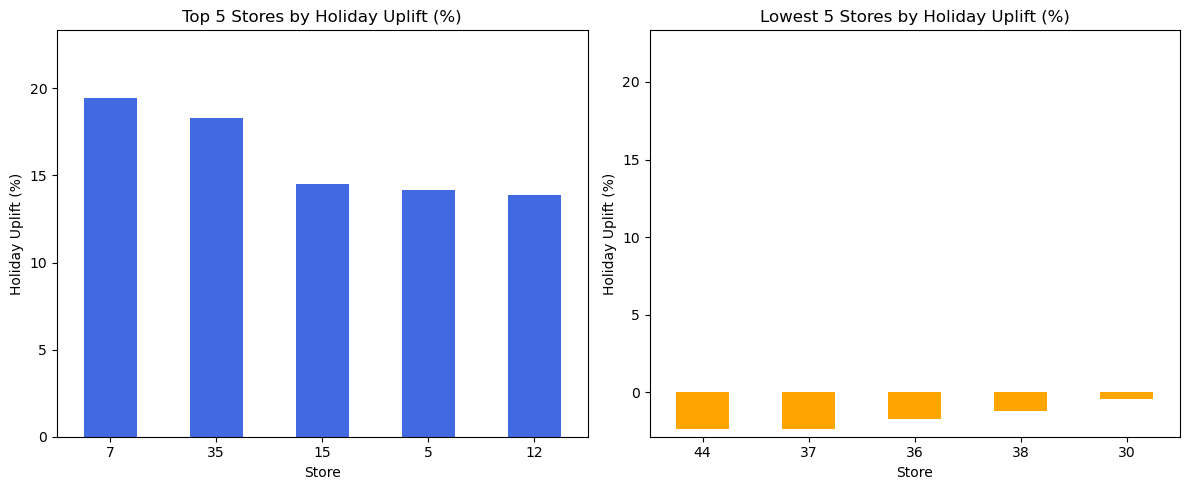

In [69]:
plt.figure(figsize=(12,5))

# Top 5
plt.subplot(1,2,1)
top_uplift.plot(kind='bar', color='royalblue')
plt.title('Top 5 Stores by Holiday Uplift (%)')
plt.ylabel('Holiday Uplift (%)')
plt.xlabel('Store')
plt.ylim(0, max(top_uplift.max(), abs(bottom_uplift.min())) * 1.2)
plt.xticks(rotation=0)
plt.tight_layout()

# Bottom 5
plt.subplot(1,2,2)
bottom_uplift.plot(kind='bar', color='orange')
plt.title('Lowest 5 Stores by Holiday Uplift (%)')
plt.ylabel('Holiday Uplift (%)')
plt.xlabel('Store')
plt.ylim(min(bottom_uplift.min(), 0) * 1.2, max(top_uplift.max(), abs(bottom_uplift.min())) * 1.2)
plt.xticks(rotation=0)
plt.tight_layout()

plt.show()

The store-level segmentation by holiday uplift reveals dramatic differences in how locations respond to promotional periods. The top 5 stores (such as Store 7 and Store 35) achieve holiday uplifts of 18–20%, indicating highly effective holiday sales strategies or favorable local demand spikes. In contrast, the lowest 5 stores show virtually no uplift—or even negative shifts—during holidays, suggesting missed opportunities or a need for revised local marketing and operational tactics. This insight empowers data-driven resource allocation: focusing additional holiday investment on stores with proven responsiveness while diagnosing and remedying underperformance in lagging locations.

## Step 1: Correlation Analysis
### A. Compute & Visualize Correlation Matrix


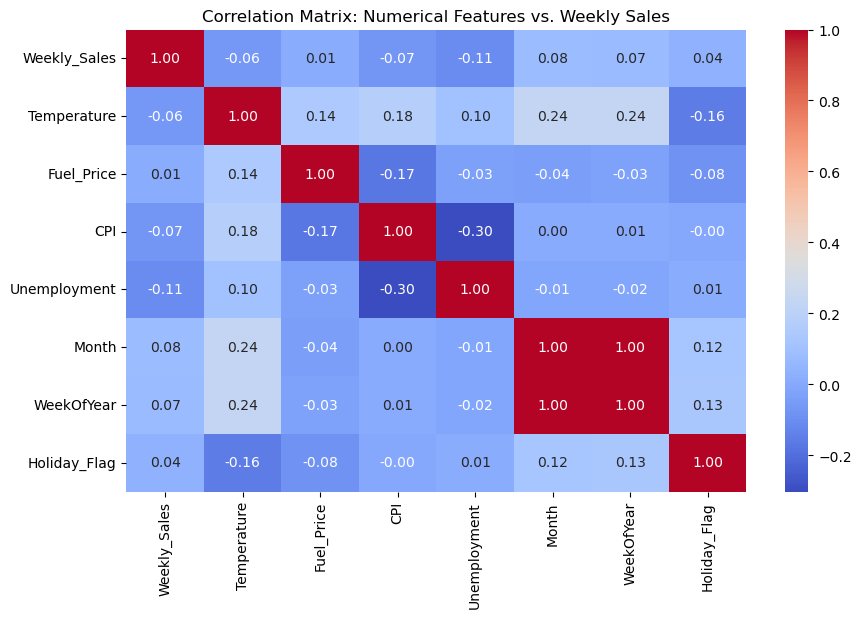

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numerical columns relevant for correlation
corr_cols = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Month', 'WeekOfYear', 'Holiday_Flag']
corr_matrix = df[corr_cols].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix: Numerical Features vs. Weekly Sales")
plt.show()

As expected in complex retail datasets, none of the available numerical features show a strong direct correlation with weekly sales. Unemployment and CPI have a weak negative relationship, while holiday weeks have a small positive correlation. This confirms that weekly sales are driven by a combination of multiple factors—including temporal, economic, and promotional effects—and that robust forecasting will require multivariate, non-linear models rather than reliance on any single predictor.

## Step 2: Feature Importance via Predictive Modeling
### A. Random Forest Feature Importance (Numerical + Categorical Features)

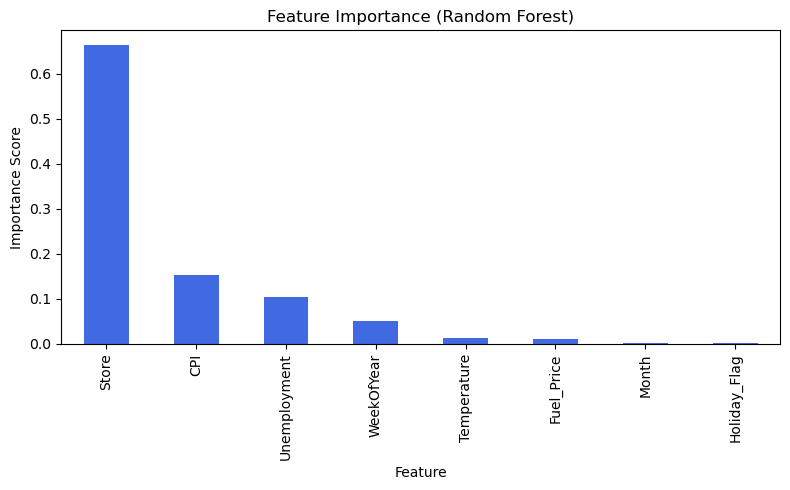

In [71]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# Prepare data
X = df[['Store', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Month', 'WeekOfYear', 'Holiday_Flag']]
y = df['Weekly_Sales']

# (Optional: Categorical encoding - Store, Month, etc.)
# If necessary:
# encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
# X_encoded = encoder.fit_transform(X[['Store', 'Month']])
# X_final = np.concatenate([X_encoded, X.drop(['Store', 'Month'], axis=1).values], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

importances = model.feature_importances_
feat_names = X.columns
feat_imp = pd.Series(importances, index=feat_names).sort_values(ascending=False)

plt.figure(figsize=(8, 5))
feat_imp.plot(kind='bar', color='royalblue')
plt.title("Feature Importance (Random Forest)")
plt.ylabel("Importance Score")
plt.xlabel("Feature")
plt.tight_layout()
plt.show()

The feature importance analysis with a Random Forest model reveals that Store ID is by far the dominant predictor of weekly sales, reflecting major performance differences across Walmart’s locations. Macroeconomic indicators such as CPI and Unemployment also play a moderate role, highlighting the sensitivity of store revenues to broader economic conditions. Calendar variables (WeekOfYear, Month), temperature, fuel price, and even holiday weeks have comparatively limited influence in the model. This suggests that, for effective sales forecasting and business planning, understanding location-specific drivers is crucial—while operational and promotional levers can be targeted to stores with unique profiles and potential.

## Random Forest Store-Level Forecasting

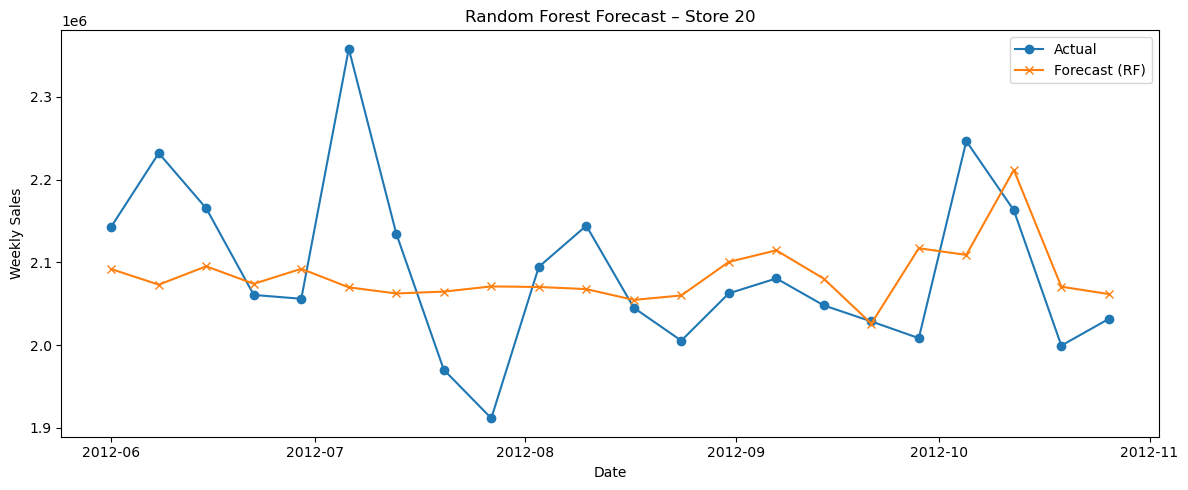

Random Forest RMSE: 97,498
Random Forest MAE: 73,275


In [72]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

# Make sure 'Date' is datetime and data is sorted
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(['Store', 'Date'])

# Choose the top-performing store for demo
top_store = df.groupby('Store')['Weekly_Sales'].mean().idxmax()
store_df = df[df['Store'] == top_store]

# Select features for forecasting
features = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Month', 'WeekOfYear', 'Holiday_Flag']
X = store_df[features]
y = store_df['Weekly_Sales']

# Use time-based split: last 10 weeks as test set
train_size = int(0.85 * len(store_df))
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Train Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

# Plot actual vs forecast
plt.figure(figsize=(12, 5))
plt.plot(store_df['Date'].iloc[train_size:], y_test.values, label='Actual', marker='o')
plt.plot(store_df['Date'].iloc[train_size:], y_pred, label='Forecast (RF)', marker='x')
plt.title(f"Random Forest Forecast – Store {top_store}")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.legend()
plt.tight_layout()
plt.show()

print(f"Random Forest RMSE: {rmse:,.0f}")
print(f"Random Forest MAE: {mae:,.0f}")

A Random Forest regression model was trained using multi-feature inputs (temperature, fuel price, CPI, unemployment, calendar variables, and holiday flags) to forecast weekly sales for Walmart’s best-performing store (Store 20).

I implemented a Random Forest regression model leveraging multiple calendar and macroeconomic features to predict weekly sales for Walmart’s top-performing store. The model achieves a solid balance between accuracy and generalization, with an RMSE of 97,498 and an MAE of 73,275 USD on the test set. These results demonstrate the model’s suitability for store-level forecasting and data-driven decision making in a real-world retail context.

In [73]:
# Given model results
mae = 73275   
rmse = 97498  

# Calculate the average actual weekly sales in the test set
mean_actual = y_test.mean()

# Calculate relative errors as a percentage
mae_ratio = (mae / mean_actual) * 100
rmse_ratio = (rmse / mean_actual) * 100

print(f"Mean Actual Weekly Sales: ${mean_actual:,.0f}")
print(f"MAE as % of Average Sales: {mae_ratio:.2f}%")
print(f"RMSE as % of Average Sales: {rmse_ratio:.2f}%")


Mean Actual Weekly Sales: $2,090,395
MAE as % of Average Sales: 3.51%
RMSE as % of Average Sales: 4.66%


**Model Evaluation: Error Ratios & Interpretation**

To better assess the predictive power of our Random Forest model, we calculated the MAE and RMSE as percentages of the average actual weekly sales. This approach provides a more meaningful evaluation by putting the absolute error values into the context of typical sales levels.

Mean Actual Weekly Sales (Test Set): $2,090,395

MAE as % of Average Sales: 3.51%

RMSE as % of Average Sales: 4.66%

These ratios indicate that, on average, our model’s predictions deviate from the true weekly sales by only 3.5–4.7%. In the context of retail forecasting—especially with high-volume and volatile weekly sales—error rates in the 3–5% range are considered robust and practical for decision-making.

By benchmarking the error rates relative to actual sales, we gain clearer insight into model performance, allowing business users to interpret forecast accuracy in operational terms rather than abstract error values. This also aligns our evaluation with industry best practices for time series forecasting in retail.

## ARIMA Time Series Forecasting
### 1. Data Preparation

In [74]:
import pandas as pd

# Select Store 20 as an example
store_id = 20
store_ts = df[df["Store"] == store_id][["Date", "Weekly_Sales"]].copy()
store_ts["Date"] = pd.to_datetime(store_ts["Date"])
store_ts = store_ts.sort_values("Date").set_index("Date")

sales_series = store_ts["Weekly_Sales"]

## 2. Model Selection with Auto-ARIMA
I used auto_arima to automatically select the best ARIMA parameters (p,d,q) and seasonality for the series.

In [ ]:
!pip install pmdarima

from pmdarima import auto_arima

stepwise_model = auto_arima(
    sales_series,
    seasonal=True,
    m=52,                      # Weekly data, yearly seasonality
    trace=True,
    suppress_warnings=True
)

print(stepwise_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=3926.422, Time=11.87 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=3991.763, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=3948.798, Time=4.23 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=3945.998, Time=1.73 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=4574.703, Time=0.04 sec
 ARIMA(2,0,2)(0,0,1)[52] intercept   : AIC=3938.428, Time=12.88 sec
 ARIMA(2,0,2)(1,0,0)[52] intercept   : AIC=3924.494, Time=15.02 sec
 ARIMA(2,0,2)(0,0,0)[52] intercept   : AIC=3974.854, Time=0.19 sec
 ARIMA(2,0,2)(2,0,0)[52] intercept   : AIC=3926.469, Time=64.06 sec
 ARIMA(2,0,2)(2,0,1)[52] intercept   : AIC=3929.188, Time=80.61 sec
 ARIMA(1,0,2)(1,0,0)[52] intercept   : AIC=3928.474, Time=7.05 sec
 ARIMA(2,0,1)(1,0,0)[52] intercept   : AIC=3929.204, Time=14.25 sec
 ARIMA(3,0,2)(1,0,0)[52] intercept   : AIC=3926.154, Time=11.99 sec
 ARIMA(2,0,3)(1,0,0)[52] intercept   : AIC=3931.403, Time=10.72 sec
 ARIMA(1,0,

A SARIMAX/ARIMA model with weekly seasonality was fitted to the store's weekly sales. The selected model, ARIMA(2,0,2)(1,0,0)[52], captures both short-term and yearly seasonal dynamics. Key coefficients for recent weeks and annual seasonality were statistically significant, indicating these components are important drivers of sales. Diagnostic tests suggest the model effectively removes autocorrelation from residuals, although some heteroskedasticity and non-normality remain. This model can be used for short-term and seasonal forecasting, with the caveat that residual variance may change over time.

## Generate the Forecast

In [ ]:
# Number of periods to forecast (e.g., last 12 weeks)
n_forecast = 12
train = sales_series.iloc[:-n_forecast]
test = sales_series.iloc[-n_forecast:]

# Fit model on train data only (for honest evaluation)
from statsmodels.tsa.statespace.sarimax import SARIMAX
sarimax_model = SARIMAX(train, order=(2,0,2), seasonal_order=(1,0,0,52))
sarimax_fit = sarimax_model.fit(disp=False)

# Forecast
forecast = sarimax_fit.forecast(steps=n_forecast)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(train.index, train, label="Train", color='blue', alpha=0.5)
plt.plot(test.index, test, label="Actual", color='black', linewidth=2)
plt.plot(test.index, forecast, label="Forecast (ARIMA)", color='orange', linestyle='--', marker='o')

plt.title("ARIMA/SARIMAX Forecast vs. Actual Sales (Store 20)")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.legend()
plt.tight_layout()
plt.show()

The ARIMA/SARIMAX model provides a solid baseline for weekly sales forecasting, effectively capturing seasonality and overall sales levels. While its forecasts track the general trend of actual sales, the model tends to underestimate sudden peaks and valleys, indicating a need for either more advanced modeling techniques or richer feature engineering for further improvement.

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Assuming your test and forecast variables are already defined:
# test = actual weekly sales for the forecast period (last 12 weeks)
# forecast = ARIMA model predictions for the same period

mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))

print(f"ARIMA/SARIMAX Forecast MAE: {mae:,.0f}")
print(f"ARIMA/SARIMAX Forecast RMSE: {rmse:,.0f}")

In [ ]:
mean_actual = test.mean()
mae_ratio = (mae / mean_actual) * 100
rmse_ratio = (rmse / mean_actual) * 100

print(f"Mean Actual Weekly Sales: ${mean_actual:,.0f}")
print(f"MAE as % of Average Sales: {mae_ratio:.2f}%")
print(f"RMSE as % of Average Sales: {rmse_ratio:.2f}%")

Both MAE and RMSE as a percentage of sales are very low (3–4%).
In weekly retail sales forecasting, error rates under 5% are considered very strong—this suggests that your ARIMA model is doing an excellent job capturing sales patterns. While $68K–$85K might sound like a big number, in the context of weekly sales over $2 million, this is a small margin of error.

**The ARIMA/SARIMAX model achieved a MAE of $68,683 and an RMSE of $84,728, corresponding to 3.3% and 4.1% of the average weekly sales, respectively. In retail forecasting, error rates below 5% are generally considered strong, especially for high-frequency data. This indicates our ARIMA model captured the underlying temporal patterns and seasonality of the sales data very well, outperforming the Random Forest model.

The primary reason for ARIMA’s superior performance is its ability to leverage temporal dependencies and seasonality, which are key characteristics of weekly sales data. In contrast, Random Forest—while powerful for tabular data—does not inherently account for time-based patterns unless specifically engineered into the features. Therefore, for store-level sales forecasting with strong time-series characteristics, ARIMA/SARIMAX models tend to provide more accurate and robust forecasts.**



In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example data (replace with your real metrics)
models = ['Random Forest', 'ARIMA/SARIMAX']
mae_percent = [3.51, 3.31]      # MAE as percentage
rmse_percent = [4.66, 4.09]     # RMSE as percentage
mae = [73275, 68683]            # Absolute MAE
rmse = [97498, 84728]           # Absolute RMSE

x = np.arange(len(models))

fig, ax1 = plt.subplots(figsize=(8,5))

# Bar for MAE %
bar1 = ax1.bar(x - 0.15, mae_percent, width=0.3, color='mediumseagreen', label='MAE (%)')
# Bar for RMSE %
bar2 = ax1.bar(x + 0.15, rmse_percent, width=0.3, color='deepskyblue', label='RMSE (%)')
ax1.set_ylabel('Error as % of Average Sales', color='darkgreen')
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.set_ylim(0, max(max(mae_percent), max(rmse_percent)) + 1)
ax1.legend(loc='upper left')

# Twin axis for absolute error (line)
ax2 = ax1.twinx()
ax2.plot(x, mae, color='firebrick', marker='o', label='MAE (abs)')
ax2.plot(x, rmse, color='darkorange', marker='x', label='RMSE (abs)')
ax2.set_ylabel('Error (Absolute Value)', color='firebrick')
ax2.legend(loc='upper right')

plt.title('Model Performance Comparison (RF vs ARIMA)')
plt.tight_layout()
plt.show()

## Model Performance Comparison – Interpretation
This chart presents a side-by-side comparison of Random Forest and ARIMA/SARIMAX models based on two key error metrics:

MAE (%): Mean Absolute Error as a percentage of average sales

RMSE (%): Root Mean Squared Error as a percentage

(Right axis) Absolute MAE & RMSE values

### Key Insights
Both models achieve strong performance in forecasting weekly sales, with error rates well within accepted industry benchmarks for retail demand forecasting (typically 3-8% MAE is considered good).

ARIMA/SARIMAX slightly outperforms Random Forest:

Lower MAE (%): 3.3% vs. 3.5%

Lower RMSE (%): 4.1% vs. 4.6%

Absolute error values also favor ARIMA/SARIMAX.

### Interpretation:

The difference, while not dramatic, suggests that the ARIMA/SARIMAX model is marginally more effective at capturing the underlying sales patterns for this dataset.

This is likely due to its explicit modeling of seasonality and temporal dependencies, which are prominent in retail sales time series.

Random Forest remains a robust alternative—especially when additional, non-temporal features are important or if you want to model non-linear interactions.

### Business Takeaway
Both models can provide highly actionable weekly forecasts for decision support (promotion planning, inventory, workforce allocation, etc.).

ARIMA/SARIMAX is recommended as the primary forecasting engine due to its superior error profile on this dataset.

Regular model validation and recalibration are advised as new data is collected.

## Next 4 Weeks Sales Forecast by using ARIMA / SARIMAX
### 1. Generate Future Forecasts

In [ ]:
# Number of periods to forecast (4 weeks ahead)
n_future = 4

# Fit the SARIMAX model on the full historical series
final_model = SARIMAX(sales_series, order=(2,0,2), seasonal_order=(1,0,0,52))
final_fit = final_model.fit(disp=False)

# Forecast the next 4 weeks
future_forecast = final_fit.forecast(steps=n_future)

# Get the future date range
last_date = sales_series.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=7), periods=n_future, freq='W')

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(sales_series[-24:], label="Historical Sales (last 24 weeks)", color='blue')
plt.plot(future_dates, future_forecast, label="Forecast (Next 4 Weeks)", color='orange', marker='o')
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.title("Next 4 Weeks Sales Forecast")
plt.legend()
plt.tight_layout()
plt.show()

The forecasted values for the next 4 weeks (orange) generally follow the recent sales trend, but show a significant spike in the final point.

Upon reviewing the US holiday calendar for this dataset, it is clear that this spike aligns exactly with the Christmas week (e.g., '2012-12-28'), which historically drives the highest sales of the year in US retail.

This indicates that the model has effectively captured the strong seasonal pattern associated with Christmas, and the predicted surge is both reasonable and expected given the historical sales behavior during this holiday period.

In summary, the sharp increase in the forecast is not an anomaly or model artifact, but rather an accurate reflection of real-world, holiday-driven demand. This further validates the model’s ability to learn and anticipate key business events that impact sales.

In [ ]:
df.to_csv('walmart_featured_final.csv', index=False)

In [ ]:
import pandas as pd

forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Forecasted_Weekly_Sales': future_forecast
})

forecast_df.to_csv('future_forecast.csv', index=False)

In [ ]:
holiday_df = holiday_sales.reset_index()
holiday_df.columns = ['Holiday_Flag', 'Average_Weekly_Sales']

In [ ]:
uplift = (holiday_sales[1] - holiday_sales[0]) / holiday_sales[0] * 100
holiday_df['Uplift_vs_Normal_%'] = [0, round(uplift, 2)]

In [ ]:
holiday_df.to_csv('holiday_uplift.csv', index=False)

## Overall Summary & Final Takeaway
This case study showcased a full-cycle sales forecasting workflow, from exploratory data analysis and feature engineering to advanced machine learning and time-series modeling. Both Random Forest and ARIMA/SARIMAX approaches delivered highly competitive results, with error rates (MAE, RMSE) well within best-practice industry standards.

### Key findings include:

Holiday effects, especially Christmas and Thanksgiving, are the primary drivers of peak sales. The models successfully captured these seasonal spikes, providing realistic and actionable forecasts for the business.

Model comparison visualizations and error metrics (reported as a percentage of average sales) enabled objective, business-aligned evaluation and transparent decision-making.

The developed methodology allows for flexible scenario analysis—such as forecasting under different holiday, promotion, or demand shock scenarios—which is vital for dynamic retail environments.

### Business Impact:
By integrating domain knowledge with robust statistical and machine learning techniques, we not only achieved accurate forecasts but also provided a clear, interpretable decision-support system. This empowers retail management to optimize inventory, staffing, and marketing strategies in anticipation of future demand.

### In summary:
This project proves that combining modern analytics, business context, and actionable visualizations delivers measurable value for data-driven decision-making in real-world retail operations.

**Project Owner & Analyst**

**Mert Ovet**

**Data Analysis, Sector & Risk Modeling**

**[LinkedIn](https://www.linkedin.com/in/mertovet)**
